#### 뉴스 기사 태그 분류 모델

In [61]:
## 모듈 로딩
from torch import nn
import pandas as pd
import numpy as np
import re               # 정규식 사용
import os               # 파일 불러오기
from torch.utils.data import Dataset, DataLoader     # Pytorch Dataset관련 모듈

from konlpy.tag import Okt
from collections import Counter

In [62]:
## 데이터 불러올때 정규식 적용해서 불러오기
def re_text(text):
    text = re.sub(r'[^\w가-힇\s]', '', text)
    text = re.sub(r'[\u4E00-\u9FFF]', '', text) # 한자 제거
    text = re.sub(r"\s*\[.*?\]", "", text) # 대괄호 제거
    text = re.sub(r"\s*\{.*?\}", "", text) # 중괄호 제거
    text = re.sub(r'\([^)]*\)', "", text) # 소괄호 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text) # 특수문자 제거
    return text.strip() # 앞뒤 공백제거


In [63]:
## 데이터셋 불러오기
FILE_PATH = r'C:\Users\KDP-14\Desktop\VSCode\LocalData\NLP_data\text_classifie_rmodel_data'

In [64]:
texts = []
labels = []

for label in range(8):
    label_folder = os.path.join(FILE_PATH,str(label))
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder,file_name)
        with open(file_path,'r',encoding='utf-8') as f:
            text = f.read()

            clean_text = re_text(text)
            texts.append(clean_text)
            labels.append(label)           

In [65]:
texts[1]

'예결위 추경 막바지 심사 진통여야 충돌\t서울연합뉴스 김남권 기자  국회 예산결산특별위원회는 19일 추가경정예산안의 막바지 심사에 돌입했으나 여야 간 이견에 진통을 겪고 있다 \n\n예결위는 이날 오전 8시 소소위원회를 열고 전날까지 심사에서 보류된 사업 53건의 감액 심사를 했다 \n\n여야 4개 교섭단체의 예결위 간사들만 참석하는 소소위는 심사한 지 한 시간 만에 여야 간 충돌로 정회했다 \n\n자유한국당 예결위 간사인 김도읍 의원은 감액할 사업이 많은데 현재 소소위가 정회된 상태라고 말했다\n\n예결위는 소소위에서의 감액 심사 완료 및 증액 작업 등을 거쳐 수정된 추경안을 전체회의에 올릴 예정이었으나 현재로서는 전체회의 개의 및 상정 전망이 불투명한 상태다 \n\n여야는 예결위 전체회의를 거쳐 이날 오후 9시 국회 본회의에서 추경안을 처리하기로 합의한 상태다 다만 예결위 전체회의가 불발될 경우 본회의에서의 추경안 처리는 어려워질 수 있다'

In [66]:
## 문장에서 \t, \n\n, \n 제거
for num in range(len(texts)):
    texts[num]=texts[num].replace('\t','')
    texts[num]=texts[num].replace('\n\n','')
    texts[num]=texts[num].replace('\n','')

In [67]:
df = pd.DataFrame({'text': texts, 'label': labels})

In [68]:
df['text']

0       동남아 담당  최희철 부상 베이징 도착싱가포르행 주목최 부상 행선지방문 목적 질문에...
1       예결위 추경 막바지 심사 진통여야 충돌서울연합뉴스 김남권 기자  국회 예산결산특별위...
2       외압 논란항명 사태산 넘고 물 건넌 권성동 영장 청구안미현 검사 외압 폭로 파문으로...
3       친문 홍영표 문빠에 찍혔다특검 합의에 문자폭탄 공격대표적인 친문재인계인 홍영표 더불...
4       연일 비난정상회담 전 경고성 메시지 발신 맥스선더태영호 등 불만 표시 최종타켓조율 ...
                              ...                        
1595    단일팀 추진 대한카누연맹 데상트코리아와 5년 후원 협약스포티비뉴스조형애 기자 대한카...
1596    올림픽 성공 뒷이야기 서울대 16일 이희범 평창 조직위원장 초청 특강OSEN이인환 ...
1597    21일 개막 호치민3쿠션월드컵에 149명 참가 확정선수 46명 참가1차 예선에 20...
1598    스포츠안전재단 대축전에 안전필요성 알려스타뉴스 채준 기자스포츠안전재단이 대축전과 장...
1599    조한승 커피 향 그윽한 30대 바둑 보이겠다한겨레 맥심커피배 트로피 시상식 열려우승...
Name: text, Length: 1600, dtype: object

In [69]:
print(f'texts number : {len(texts)}')
print(f'labels number : {len(labels)}')

texts number : 1600
labels number : 1600


#### 데이터 토큰화 및 단어 사전 구축 <hr>

In [123]:
### 단어 사전을 생성시에 활용
def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    return vocab


In [79]:
df

,text,label
0,동남아 담당 최희철 부상 베이징 도착싱가포르행 주목최 부상 행선지방문 목적 질문에...,0
1,예결위 추경 막바지 심사 진통여야 충돌서울연합뉴스 김남권 기자 국회 예산결산특별위...,0
2,외압 논란항명 사태산 넘고 물 건넌 권성동 영장 청구안미현 검사 외압 폭로 파문으로...,0
3,친문 홍영표 문빠에 찍혔다특검 합의에 문자폭탄 공격대표적인 친문재인계인 홍영표 더불...,0
4,연일 비난정상회담 전 경고성 메시지 발신 맥스선더태영호 등 불만 표시 최종타켓조율 ...,0
...,...,...
1595,단일팀 추진 대한카누연맹 데상트코리아와 5년 후원 협약스포티비뉴스조형애 기자 대한카...,7
1596,올림픽 성공 뒷이야기 서울대 16일 이희범 평창 조직위원장 초청 특강OSEN이인환 ...,7
1597,21일 개막 호치민3쿠션월드컵에 149명 참가 확정선수 46명 참가1차 예선에 20...,7
1598,스포츠안전재단 대축전에 안전필요성 알려스타뉴스 채준 기자스포츠안전재단이 대축전과 장...,7


In [81]:
# 명사만 추출
from konlpy.tag import Okt

okt = Okt()

df['token'] = df.apply(lambda row: okt.nouns(row['text']), axis=1)

#### 불용어 list <hr>

In [83]:
korea_stopword = r'C:\Users\KDP-14\Desktop\VSCode\KDT6\Torch_NLP\DAY10_07\stopwords.txt'

with open(korea_stopword, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# 리스트 형태로 저장하기
lines = [line.strip() for line in lines]

* 불용어 & 구두점 제거

In [84]:
## 불용어 추출
from nltk.corpus import stopwords
import string

eng_stopwords = stopwords.words('english') # 리스트 형태
pun = list(string.punctuation) # 구두점 => 문자열 형태임 => 리스트로 형변환

In [85]:
stopwords = lines + pun
stopwords

['가',
 '가까스로',
 '가령',
 '각',
 '각각',
 '각자',
 '각종',
 '갖고말하자면',
 '같다',
 '같이',
 '개의치않고',
 '거니와',
 '거바',
 '거의',
 '것',
 '것과 같이',
 '것들',
 '게다가',
 '게우다',
 '겨우',
 '견지에서',
 '결과에 이르다',
 '결국',
 '결론을 낼 수 있다',
 '겸사겸사',
 '고려하면',
 '고로',
 '곧',
 '공동으로',
 '과',
 '과연',
 '관계가 있다',
 '관계없이',
 '관련이 있다',
 '관하여',
 '관한',
 '관해서는',
 '구',
 '구체적으로',
 '구토하다',
 '그',
 '그들',
 '그때',
 '그래',
 '그래도',
 '그래서',
 '그러나',
 '그러니',
 '그러니까',
 '그러면',
 '그러므로',
 '그러한즉',
 '그런 까닭에',
 '그런데',
 '그런즉',
 '그럼',
 '그럼에도 불구하고',
 '그렇게 함으로써',
 '그렇지',
 '그렇지 않다면',
 '그렇지 않으면',
 '그렇지만',
 '그렇지않으면',
 '그리고',
 '그리하여',
 '그만이다',
 '그에 따르는',
 '그위에',
 '그저',
 '그중에서',
 '그치지 않다',
 '근거로',
 '근거하여',
 '기대여',
 '기점으로',
 '기준으로',
 '기타',
 '까닭으로',
 '까악',
 '까지',
 '까지 미치다',
 '까지도',
 '꽈당',
 '끙끙',
 '끼익',
 '나',
 '나머지는',
 '남들',
 '남짓',
 '너',
 '너희',
 '너희들',
 '네',
 '넷',
 '년',
 '논하지 않다',
 '놀라다',
 '누가 알겠는가',
 '누구',
 '다른',
 '다른 방면으로',
 '다만',
 '다섯',
 '다소',
 '다수',
 '다시 말하자면',
 '다시말하면',
 '다음',
 '다음에',
 '다음으로',
 '단지',
 '답다',
 '당신',
 '당장',
 '대로 하다',
 '대하면',
 '대하여',
 '대해 말하자면',
 '대해서',
 '댕그',


In [86]:
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

In [91]:
df['token'] = df['token'].apply(lambda tokens: remove_stopwords(tokens))

In [92]:
## train과 test 데이터셋 나누기
train = df.sample(frac=0.9, random_state=42)
test = df.drop(train.index)

print("Traing Data Size : ", len(train))
print("Test Data Size : ", len(test))


Traing Data Size :  1440
Test Data Size :  160


In [94]:
# 토큰화
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords ] for review in train.text]   # 형태소 단위로 나눠서 리스트에 저장
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in test.text]

# 토큰화 된걸 사전으로 만듬
vocab = build_vocab(corpus = train_tokens,n_vocab=7000,special_tokens=["<pad>","<unk>"])

# 맵핑 부분분
token_to_id = {token : idx for idx, token in enumerate(vocab)}
id_to_token = {idx : token for idx, token in enumerate(vocab)}

print(vocab[:10])

['<pad>', '<unk>', '은', '는', '한', '\xa0', '했다', '도', '하는', '수']


In [95]:
vocab

['<pad>',
 '<unk>',
 '은',
 '는',
 '한',
 '\xa0',
 '했다',
 '도',
 '하는',
 '수',
 '적',
 '인',
 '할',
 '이다',
 '해',
 '하고',
 '말',
 '된',
 '전',
 '다',
 '기자',
 '있는',
 '한국',
 '고',
 '씨',
 '1',
 '명',
 '서울',
 '위',
 '2',
 '이라고',
 '지난',
 '대',
 '에는',
 '날',
 '북한',
 '됐다',
 '3',
 '미국',
 '대해',
 '대한',
 '중',
 '당',
 '성',
 '한다',
 '못',
 '때문',
 '통해',
 '밝혔다',
 '안',
 '사람',
 '만',
 '장',
 '위해',
 '관련',
 '대통령',
 '중국',
 '된다',
 '서',
 '경찰',
 '더',
 '될',
 '이후',
 '정부',
 '내',
 '같은',
 '하지',
 '원',
 '지',
 '대표',
 '에서는',
 'A',
 '사실',
 '문제',
 '보다',
 '개',
 '게',
 '기',
 '있다고',
 '두',
 '조사',
 '경우',
 '지난해',
 '뒤',
 '관계자',
 '했다고',
 '혐의',
 '세',
 '상황',
 '되는',
 '김',
 '후보',
 '점',
 '대회',
 '주',
 '최근',
 '따르면',
 '4',
 '의원',
 '후',
 '연',
 '진행',
 '에도',
 '달',
 '현재',
 '하기',
 '간',
 '라고',
 '시장',
 '확인',
 '5',
 '상',
 '하며',
 '돼',
 '예정',
 '해야',
 '설명',
 '하면',
 '주장',
 '입니다',
 '팀',
 '결과',
 '시작',
 '이나',
 '세계',
 '뉴스',
 '지역',
 '오후',
 '한다고',
 '이어',
 '회담',
 '정도',
 '경기',
 '차',
 '입장',
 '생각',
 '있다는',
 '가격',
 '트럼프',
 '큰',
 '곳',
 '사건',
 '모습',
 '정상회담',
 '데',
 '방송',
 '건',
 '국내',


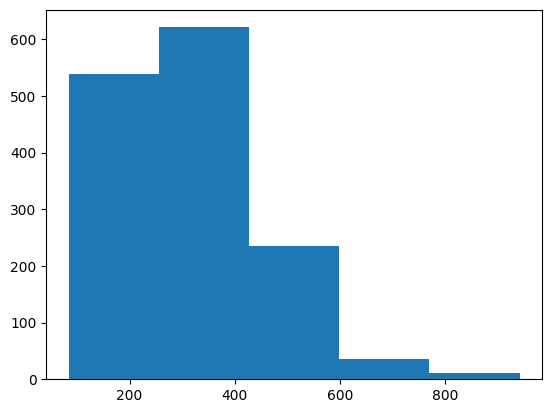

In [122]:
## 패딩을 위한 문장길이 히스토그램
import matplotlib.pyplot as plt

# for tokens in train_tokens:
#     print(len(tokens))
#     break
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=5)
plt.show()

In [99]:
# 못걸러진 불용어 찾기
all_tokens = [token for tokens in train_tokens for token in tokens]
token_counts = Counter(all_tokens)
frequencies = list(token_counts.values())

token_counts.most_common(40)

## 은,는 같은 불용어가 존재... 불용어 리스트 수정 필요

[('은', 8406),
 ('는', 7389),
 ('한', 5557),
 ('\xa0', 4940),
 ('했다', 4868),
 ('도', 2734),
 ('하는', 2480),
 ('수', 2427),
 ('적', 2337),
 ('인', 2099),
 ('할', 2000),
 ('이다', 1982),
 ('해', 1981),
 ('하고', 1879),
 ('말', 1553),
 ('된', 1496),
 ('전', 1441),
 ('다', 1255),
 ('기자', 1146),
 ('있는', 1096),
 ('한국', 1056),
 ('고', 1049),
 ('씨', 1021),
 ('1', 986),
 ('명', 964),
 ('서울', 945),
 ('위', 910),
 ('2', 878),
 ('이라고', 859),
 ('지난', 847),
 ('대', 838),
 ('에는', 832),
 ('날', 777),
 ('북한', 768),
 ('됐다', 744),
 ('3', 739),
 ('미국', 727),
 ('대해', 714),
 ('대한', 710),
 ('중', 702)]

In [100]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  #입력받는 sequences는 리스트형태
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] # 시퀀스가 max_lenth보다 길경우 뒷부분을 자른다
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   # 시퀀스가 짧을경우 남은부분을 0으로 채움
        result.append(padded_sequence)
    return np.asarray(result)

In [103]:
unk_id = token_to_id["<unk>"]   # 단어사전에 없는 단어를 처리할때
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  # 각 토큰에 대응하는 정수 ID반환, 존재하지않으면 unk
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 500
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[1398 2655  315  360   91  270   26 6356    1  495 3907 5164    1  162
    1 1066 1398 2655    1  315 6357   69   98    1  360   25 3331  184
 5165  262 3908   91  270   26  979  113   94 1398   22 1961  735  856
    1  495 3907 5164    6   94 1398   22 1961    2  856 1587  195 1758
   14   31  361  417   31  991 1398 3474 6357   91  270   26    1 3332
   48  228  417  114   17 6357  360    3 3741   10 1326  185    1 4119
  106 2751  728 5523 3074 4332   23 6357  360    3 1029  825  826 1428
   46 3592  280    1  114 3475 4120 1588   23 4596   55 1723  534 1327
  173  599  947  395    6   22 1961    2    1 6917 6358 5931 6359 6360
  701  610 2656   15  495 5932 3210 2003 1485    6   22 1961    2  360
  364   33 1759    1 1214    1    1  686    1 1094 5524   54    1    1
    1    1 1876 2003   49   64    6    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### 모델 준비

In [104]:
## 데이터로더
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.long)
test_labels = torch.tensor(test.label.values, dtype=torch.long)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [105]:
for feature, label in train_loader:
    print(feature)
    print(label)
    break

tensor([[2826,    1,   52,  ...,    0,    0,    0],
        [2488, 3729, 1124,  ...,    0,    0,    0],
        [1777,    1, 5644,  ...,    0,    0,    0],
        ...,
        [1139, 1159,    1,  ...,    0,    0,    0],
        [2850,  901, 1082,  ...,    0,    0,    0],
        [ 549,  346,    1,  ...,    0,    0,    0]], dtype=torch.int32)
tensor([7, 7, 7, 7, 7, 5, 2, 5, 5, 2, 5, 3, 7, 3, 5, 7])


In [108]:
from torch import nn

class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        n_classes,
        dropout = 0.5,
        bidirectional = True,
        model_type = 'lstm'):

        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        if model_type == 'rnn':
            self.model = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True,
        )
        elif model_type == 'lstm':
            self.model = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True,
            )
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2,n_classes)
        else:
            self.classifier = nn.Linear(hidden_dim,1,n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self,inputs):
        embeddings = self.embedding(inputs)
        output,_ = self.model(embeddings)
        last_output = output[:,-1,:]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [110]:
## 손실 함수와 최적화 함수 정의
from torch import optim

n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 64     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 2   
n_classes = 8 

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)   # 다중분류라서
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

[4] 모델 학습

In [111]:
def train(model,datasets,criterion,optimizer,device,interval):
    model.train()
    losses = list()

    for step,(input_ids,labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)
        loss = criterion(logits,labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval ==0:
            print(f'Train Loss {step} : {np.mean(losses)}')

def test(model,datasets,criterion,device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids,labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)
        loss = criterion(logits,labels)
        losses.append(loss.item())
        yhat = torch.argmax(logits, dim=1)
        corrects.extend(
            torch.eq(yhat,labels).cpu().tolist()
        )
    print(f'Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}')


In [112]:
epochs =10
interval = 500   #500번 미니배치마다 손실출력

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 2.0945169925689697
Val Loss : 2.062255024909973, Val Accuracy : 0.1375
Train Loss 0 : 2.0269079208374023
Val Loss : 2.0684995651245117, Val Accuracy : 0.15
Train Loss 0 : 2.1408612728118896
Val Loss : 2.049927067756653, Val Accuracy : 0.1625
Train Loss 0 : 2.081113815307617
Val Loss : 2.052144968509674, Val Accuracy : 0.16875
Train Loss 0 : 2.1508123874664307
Val Loss : 2.0379220843315125, Val Accuracy : 0.14375
Train Loss 0 : 1.9751498699188232
Val Loss : 2.028170275688171, Val Accuracy : 0.14375
Train Loss 0 : 1.9411966800689697
Val Loss : 2.044404900074005, Val Accuracy : 0.1625
Train Loss 0 : 1.9542655944824219
Val Loss : 2.060810697078705, Val Accuracy : 0.14375
Train Loss 0 : 1.6575263738632202
Val Loss : 2.024563419818878, Val Accuracy : 0.16875
Train Loss 0 : 1.9893171787261963
Val Loss : 2.026820123195648, Val Accuracy : 0.175
